## Emergency Modeling

In [1]:
import pandas as pd
from base.influx_utils import fetch_all_sensor_data
from occupancy_model import (
    prepare_data_for_occupancy_model,
    train_occupancy_model,
    map_sensor_to_room,
    calculate_times_in_each_room
)
from base.minio_utils import save_model_to_minio, load_model_from_minio

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [15]:
# Fetch sensor data
sensor_data = fetch_all_sensor_data(start_hours=24*7*20, interval_hours=24*7*20)
sensor_data_df = prepare_data_for_occupancy_model(sensor_data)

In [16]:
sensor_data_df

,sensor,bucket,timestamp,value,type,sensor_encoded
0,kitchen_PIR,1_5_9,2024-10-31 12:14:06.000,corridor,sensor,1
1,kitchen_PIR,1_5_9,2024-10-31 12:14:39.000,corridor,sensor,1
2,kitchen_PIR,1_5_9,2024-10-31 12:18:29.000,kitchen,sensor,1
3,kitchen_PIR,1_5_9,2024-10-31 12:18:54.000,kitchen,sensor,1
4,kitchen_PIR,1_5_9,2024-10-31 12:19:18.000,kitchen,sensor,1
...,...,...,...,...,...,...
18392,livingroom_PIR,1_4_7,2025-01-19 15:28:39.948,livingroombedarea,sensor,2
18393,livingroom_PIR,1_4_7,2025-01-19 15:29:04.851,livingroombedarea,sensor,2
18394,livingroom_PIR,1_4_7,2025-01-19 15:32:21.232,livingroombedarea,sensor,2
18395,livingroom_PIR,1_4_7,2025-01-19 15:32:27.013,livingroombedarea,sensor,2


### Sensor data for the report

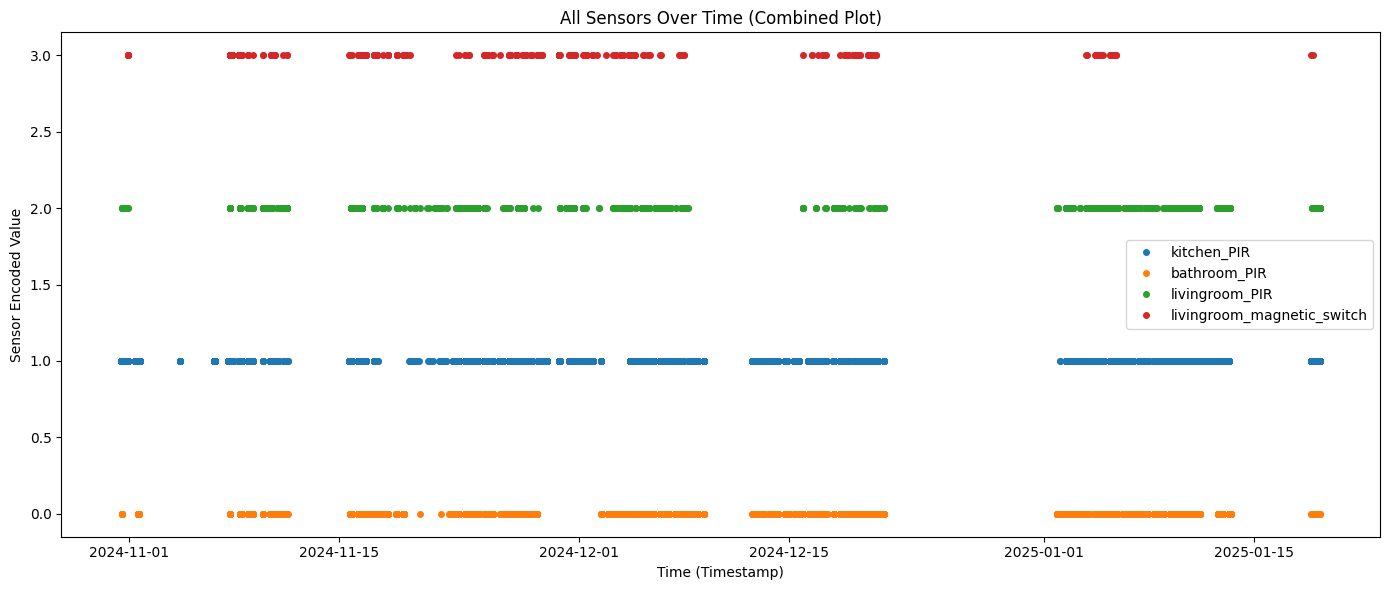

In [33]:
import matplotlib.pyplot as plt

# Assume 'sensor_data_df' has columns: ['timestamp', 'sensor', 'sensor_encoded']
unique_sensors = sensor_data_df['sensor'].unique()

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each sensor's data on the same axis
for sensor in unique_sensors:
    sensor_data = sensor_data_df[sensor_data_df['sensor'] == sensor]
    ax.plot(
        sensor_data['timestamp'],
        sensor_data['sensor_encoded'],
        marker='o',
        linestyle='None',
        markersize=4,
        label=sensor
    )

ax.set_title('All Sensors Over Time (Combined Plot)')
ax.set_xlabel('Time (Timestamp)')
ax.set_ylabel('Sensor Encoded Value')
ax.legend()
plt.tight_layout()
fig.savefig('all_sensors_data.pdf')
plt.show()

In [25]:
import pandas as pd

df = sensor_data_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)


In [26]:
threshold = pd.Timedelta(days=2)


In [27]:
timestamps = df['timestamp'].values  # Sorted array of timestamps

gaps = []
for i in range(len(timestamps) - 1):
    diff = timestamps[i+1] - timestamps[i]
    if diff > threshold:
        gaps.append((
            pd.to_datetime(timestamps[i]),     # end of the earlier record
            pd.to_datetime(timestamps[i+1]),   # start of the later record
            diff
        ))

print("Detected Gaps (start, end, gap_size):")
for g in gaps:
    print(g)


Detected Gaps (start, end, gap_size):
(Timestamp('2024-11-01 17:53:35'), Timestamp('2024-11-04 09:55:53'), np.timedelta64(230538000000000,'ns'))
(Timestamp('2024-11-04 10:35:12'), Timestamp('2024-11-06 16:25:45'), np.timedelta64(193833000000000,'ns'))
(Timestamp('2024-11-11 14:48:10'), Timestamp('2024-11-15 17:14:53'), np.timedelta64(354403000000000,'ns'))
(Timestamp('2024-12-09 08:52:46.515000'), Timestamp('2024-12-12 13:30:24.962000'), np.timedelta64(275858447000000,'ns'))
(Timestamp('2024-12-21 08:50:27.687000'), Timestamp('2025-01-01 20:36:57.317000'), np.timedelta64(992789630000000,'ns'))
(Timestamp('2025-01-13 10:17:53.313000'), Timestamp('2025-01-18 19:32:26'), np.timedelta64(465272687000000,'ns'))


In [31]:
import numpy as np

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['sensor', 'timestamp']).reset_index(drop=True)

threshold = pd.Timedelta(days=2)
gap_list = []

for sensor, group in df.groupby('sensor'):
    group_timestamps = group['timestamp'].values  # Already sorted within this sensor
    
    sensor_gaps = []
    for i in range(len(group_timestamps) - 1):
        diff = group_timestamps[i+1] - group_timestamps[i]
        if diff > threshold:
            sensor_gaps.append((
                pd.to_datetime(group_timestamps[i]),
                pd.to_datetime(group_timestamps[i+1]),
                diff
            ))
    
    # Only add to gap_list if there are any gaps for this sensor
    if sensor_gaps:
        gap_list.append({
            'sensor': sensor,
            'gaps': sensor_gaps
        })

# Convert nanoseconds to days
for item in gap_list:
    print(f"Sensor: {item['sensor']}")
    for g in item['gaps']:
        gap_in_days = g[2] / np.timedelta64(1, 'D')
        print(f"  Gap: start={g[0]}, end={g[1]}, duration={round(gap_in_days)} days")


Sensor: bathroom_PIR
  Gap: start=2024-11-01 17:15:04, end=2024-11-07 17:58:05, duration=6 days
  Gap: start=2024-11-11 14:46:39, end=2024-11-15 17:21:17, duration=4 days
  Gap: start=2024-11-28 05:56:33.671000, end=2024-12-02 11:16:24.257000, duration=4 days
  Gap: start=2024-12-09 08:52:46.515000, end=2024-12-12 13:31:36.880000, duration=3 days
  Gap: start=2024-12-21 08:50:27.687000, end=2025-01-01 20:36:57.317000, duration=11 days
  Gap: start=2025-01-13 10:17:53.313000, end=2025-01-18 19:34:04.073000, duration=5 days
Sensor: kitchen_PIR
  Gap: start=2024-11-01 17:53:35, end=2024-11-04 09:55:53, duration=3 days
  Gap: start=2024-11-04 10:35:12, end=2024-11-06 16:25:45, duration=2 days
  Gap: start=2024-11-11 14:48:10, end=2024-11-15 17:14:53, duration=4 days
  Gap: start=2024-11-17 14:50:51, end=2024-11-19 17:10:26.799000, duration=2 days
  Gap: start=2024-12-09 07:30:38.162000, end=2024-12-12 13:30:24.962000, duration=3 days
  Gap: start=2024-12-21 08:08:57.260000, end=2025-01-02 

### Continue of the modeling part

In [6]:
sensor_data_df_aggregated = calculate_times_in_each_room(sensor_data_df) # It will also exclude door events after aggregation
sensor_data_df_aggregated.head(10)

,group_id,room,start_time,end_time,duration,duration_seconds
0,1,kitchen,2025-01-05 09:47:49.083,2025-01-05 09:59:00.648,0 days 00:11:11.565000,671.565
1,2,livingroom,2025-01-05 09:59:59.562,2025-01-05 10:00:51.983,0 days 00:00:52.421000,52.421
2,3,kitchen,2025-01-05 10:01:34.855,2025-01-05 10:08:53.205,0 days 00:07:18.350000,438.350
3,4,bathroom,2025-01-05 10:40:09.336,2025-01-05 10:41:58.183,0 days 00:01:48.847000,108.847
5,6,bathroom,2025-01-05 10:48:17.983,2025-01-05 10:49:48.752,0 days 00:01:30.769000,90.769
6,7,kitchen,2025-01-05 10:54:28.136,2025-01-05 10:54:28.136,0 days 00:00:00,0.000
7,8,bathroom,2025-01-05 10:55:12.990,2025-01-05 10:55:18.683,0 days 00:00:05.693000,5.693
8,9,kitchen,2025-01-05 10:55:19.763,2025-01-05 10:55:19.763,0 days 00:00:00,0.000
9,10,bathroom,2025-01-05 10:55:25.251,2025-01-05 10:55:25.251,0 days 00:00:00,0.000
10,11,kitchen,2025-01-05 10:55:27.026,2025-01-05 10:55:39.167,0 days 00:00:12.141000,12.141


In [19]:
sensor_data_df_aggregated.groupby("room").count()

,group_id,start_time,end_time,duration,duration_seconds
room,,,,,
bathroom,3,3,3,3,3
kitchen,4,4,4,4,4


In [10]:
sensor_data_df

,sensor,bucket,timestamp,value,type,sensor_encoded
0,kitchen_PIR,1_5_9,2024-11-10 15:58:56,kitchen,sensor,1
1,kitchen_PIR,1_5_9,2024-11-10 15:59:23,kitchen,sensor,1
2,kitchen_PIR,1_5_9,2024-11-10 15:59:53,kitchen,sensor,1
3,kitchen_PIR,1_5_9,2024-11-10 16:00:13,kitchen,sensor,1
4,kitchen_PIR,1_5_9,2024-11-10 16:00:24,kitchen,sensor,1
...,...,...,...,...,...,...
1111,kitchen_PIR,1_5_9,2024-11-17 14:43:29,kitchen,sensor,1
1112,kitchen_PIR,1_5_9,2024-11-17 14:50:51,kitchen,sensor,1
1862,bathroom_PIR,1_3_6,2024-11-17 15:34:43,bathroom,sensor,0
1863,bathroom_PIR,1_3_6,2024-11-17 15:35:01,bathroom,sensor,0


In [ ]:
stats_df = train_occupancy_model(sensor_data_df)
save_model_to_minio(stats_df, "occupancy")

Fetch Times Statistics: {'mean': np.float64(1.9933813095092774), 'std': np.float64(0.2480232991184939), 'min': np.float64(1.6850674152374268), 'max': np.float64(2.492304563522339)}
Train Times Statistics: {'mean': np.float64(0.01293354034423828), 'std': np.float64(0.0009571561838055074), 'min': np.float64(0.012096166610717773), 'max': np.float64(0.015254020690917969)}
Save Times Statistics: {'mean': np.float64(0.11821773052215576), 'std': np.float64(0.047292866125379904), 'min': np.float64(0.08230710029602051), 'max': np.float64(0.23515725135803223)}


In [ ]:
stats1 = load_model_from_minio("occupancy", 1)
stats2 = load_model_from_minio("occupancy", 2)

In [ ]:
stats1

,room,mean,std
0,bathroom,906.331600,2345.213762
1,kitchen,213.838955,474.832911
2,livingroom,317.616000,1220.240813


In [ ]:
# Second to last model
stats2

,room,mean,std
0,bathroom,208.242158,421.324547
1,kitchen,636.825295,1217.544011
2,livingroom,79.945778,115.666383


## Motion Modeling

In [18]:
from motion_model import train_motion_model
from base.minio_utils import save_model_to_minio, load_model_from_minio

In [20]:
motion_model1 = train_motion_model(start_hours=24*7*8, interval_hours=24*7, time_threshold_seconds=1800)
motion_model2 = train_motion_model(start_hours=24*7*7, interval_hours=24*7, time_threshold_seconds=1800)

Motion Model Train Times Statistics: {'mean': np.float64(2.905507802963257), 'std': np.float64(0.2893729897119937), 'min': np.float64(2.62494158744812), 'max': np.float64(3.7268452644348145)}
Motion Model Save Times Statistics: {'mean': np.float64(0.5269936800003052), 'std': np.float64(0.07526847007506333), 'min': np.float64(0.39025354385375977), 'max': np.float64(0.6351010799407959)}


In [26]:
motion_model1

,from,to,leave_time,enter_time
0,kitchen,bathroom,2024-11-24 16:02:04.322,2024-11-24 16:02:05.204
1,bathroom,kitchen,2024-11-24 16:02:05.204,2024-11-24 16:02:23.951
2,kitchen,bathroom,2024-11-24 16:04:02.617,2024-11-24 16:04:11.648
3,bathroom,kitchen,2024-11-24 16:04:11.648,2024-11-24 16:04:20.137
4,kitchen,bathroom,2024-11-24 16:04:20.137,2024-11-24 16:04:58.695
...,...,...,...,...
422,livingroomdoor,kitchen,2024-12-01 12:10:31.000,2024-12-01 12:11:12.831
423,kitchen,livingroomdoor,2024-12-01 12:17:40.608,2024-12-01 12:22:02.000
424,livingroomdoor,kitchen,2024-12-01 12:22:02.000,2024-12-01 12:23:32.887
425,kitchen,livingroomdoor,2024-12-01 12:36:53.281,2024-12-01 12:39:10.000


In [20]:
motion_model2

,from,to,leave_time,enter_time
0,kitchen,bathroom,2024-12-08 14:02:34.353,2024-12-08 14:05:23.532
1,bathroom,kitchen,2024-12-08 14:07:14.939,2024-12-08 14:09:24.128
2,kitchen,bathroom,2024-12-08 14:10:08.013,2024-12-08 14:15:08.211
3,bathroom,kitchen,2024-12-08 14:15:37.553,2024-12-08 14:15:56.133
4,kitchen,bathroom,2024-12-08 14:15:56.133,2024-12-08 14:20:33.772
...,...,...,...,...
487,bathroom,kitchen,2024-12-15 12:18:17.364,2024-12-15 12:19:24.953
488,kitchen,bathroom,2024-12-15 12:20:35.723,2024-12-15 12:36:42.365
489,bathroom,kitchen,2024-12-15 12:48:38.732,2024-12-15 12:51:33.558
490,kitchen,bathroom,2024-12-15 12:53:27.482,2024-12-15 12:54:07.092


In [29]:
save_model_to_minio(motion_model2, "motion")
# save_model_to_minio(motion_model1, "motion")

In [30]:
old = load_model_from_minio("motion", 2)
new = load_model_from_minio("motion", 1)

In [31]:
old

,from,to,leave_time,enter_time
0,kitchen,bathroom,2024-11-24 16:02:04.322,2024-11-24 16:02:05.204
1,bathroom,kitchen,2024-11-24 16:02:05.204,2024-11-24 16:02:23.951
2,kitchen,bathroom,2024-11-24 16:04:02.617,2024-11-24 16:04:11.648
3,bathroom,kitchen,2024-11-24 16:04:11.648,2024-11-24 16:04:20.137
4,kitchen,bathroom,2024-11-24 16:04:20.137,2024-11-24 16:04:58.695
...,...,...,...,...
422,livingroomdoor,kitchen,2024-12-01 12:10:31.000,2024-12-01 12:11:12.831
423,kitchen,livingroomdoor,2024-12-01 12:17:40.608,2024-12-01 12:22:02.000
424,livingroomdoor,kitchen,2024-12-01 12:22:02.000,2024-12-01 12:23:32.887
425,kitchen,livingroomdoor,2024-12-01 12:36:53.281,2024-12-01 12:39:10.000


In [32]:
new

,from,to,leave_time,enter_time
0,kitchen,livingroomdoor,2024-12-01 20:31:42.731,2024-12-01 20:36:45.000
1,livingroomdoor,kitchen,2024-12-01 20:36:45.000,2024-12-01 20:39:15.834
2,kitchen,livingroomdoor,2024-12-01 21:58:06.390,2024-12-01 21:59:50.000
3,livingroomdoor,kitchen,2024-12-01 21:59:50.000,2024-12-01 22:10:11.228
4,kitchen,livingroomdoor,2024-12-01 22:10:40.673,2024-12-01 22:12:10.000
...,...,...,...,...
498,bathroom,kitchen,2024-12-08 12:51:59.194,2024-12-08 12:52:46.221
499,kitchen,bathroom,2024-12-08 12:53:01.321,2024-12-08 12:53:09.409
500,bathroom,kitchen,2024-12-08 13:06:21.121,2024-12-08 13:21:58.340
501,kitchen,bathroom,2024-12-08 14:02:34.353,2024-12-08 14:05:23.532


## Burglary Model

In [22]:
from burglary_model import train_burglary_model

In [29]:
train_burglary_model(start_hours=24*7*6, interval_hours=24*7*5, time_threshold_seconds=1800)

Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Model training completed.
Burglary Model Train Times Statistics: {'mean': np.float64(2.9257815361022947), 'std': np.float64(0.1405066913537994), 'min': np.float64(2.744503974914551), 'max': np.float64(3.222346305847168)}


In [ ]:
from motion_model import train_motion_model
from base.minio_utils import load_model_from_minio, save_model_to_minio
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import base64
from io import BytesIO, StringIO
import json
from typing import Optional

In [ ]:
motion_model = train_motion_model(start_hours = 24 * 7 * 8, interval_hours= 24 * 7 * 8, time_threshold_seconds =1800)

In [ ]:
motion_model.head(10)

,from,to,leave_time,enter_time
0,livingroomdoor,kitchen,2024-11-08 22:53:03,2024-11-08 22:53:47
1,kitchen,bathroom,2024-11-08 23:17:30,2024-11-08 23:17:42
2,bathroom,livingroombedarea,2024-11-08 23:23:00,2024-11-08 23:23:28
3,livingroombedarea,livingroomdoor,2024-11-08 23:23:28,2024-11-08 23:23:57
4,livingroomdoor,kitchen,2024-11-08 23:23:57,2024-11-08 23:24:02
5,kitchen,livingroombedarea,2024-11-08 23:24:20,2024-11-08 23:24:31
6,livingroombedarea,livingroomdoor,2024-11-08 23:38:19,2024-11-08 23:38:33
7,livingroomdoor,kitchen,2024-11-08 23:38:33,2024-11-08 23:38:38
8,kitchen,livingroombedarea,2024-11-08 23:39:13,2024-11-08 23:39:57
9,livingroombedarea,livingroomdoor,2024-11-09 07:10:22,2024-11-09 07:10:55


In [ ]:
class BurglaryDetector:
    def __init__(self, contamination='auto', random_state=42, model_type: str = 'burglary'):
        """
        Initializes the BurglaryDetector with specified Isolation Forest parameters.

        Parameters:
        - contamination: float, 'auto' or float, the proportion of anomalies in the data set.
        - random_state: int, random seed for reproducibility.
        - model_type: str, identifier for the model type (used in MinIO storage).
        """
        self.contamination = contamination
        self.random_state = random_state
        self.model = None
        self.preprocessor = None
        self.feature_columns = None
        self.model_type = model_type  # e.g., 'burglary'

    def _feature_engineering(self, df: pd.DataFrame):
        """
        Performs feature engineering on the DataFrame.

        Parameters:
        - df: pandas DataFrame with columns ['from', 'to', 'leave_time', 'enter_time'].

        Returns:
        - df_features: pandas DataFrame with engineered features for modeling.
        - df_original: pandas DataFrame with original and some engineered features for reporting.
        """
        # Retain original timestamps and additional features for reporting
        df_original = df[['from', 'to', 'leave_time', 'enter_time']].copy()

        # Encode categorical variables
        categorical_features = ['from', 'to']
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ],
            remainder='passthrough'  # Keep other columns
        )

        # Convert datetime columns
        df['leave_time'] = pd.to_datetime(df['leave_time'])
        df['enter_time'] = pd.to_datetime(df['enter_time'])

        # Feature engineering: duration and temporal features
        df['duration'] = (df['enter_time'] - df['leave_time']).dt.total_seconds()

        # Extract temporal features from leave_time
        df['leave_hour'] = df['leave_time'].dt.hour
        df['leave_minute'] = df['leave_time'].dt.minute
        df['leave_second'] = df['leave_time'].dt.second

        # Extract temporal features from enter_time
        df['enter_hour'] = df['enter_time'].dt.hour
        df['enter_minute'] = df['enter_time'].dt.minute
        df['enter_second'] = df['enter_time'].dt.second

        # Retain 'duration' and 'leave_hour' in df_original for visualization
        df_original['duration'] = df['duration']
        df_original['leave_hour'] = df['leave_hour']

        # Drop original datetime columns
        df.drop(['leave_time', 'enter_time'], axis=1, inplace=True)

        # The DataFrame to be used for modeling
        df_features = df.copy()

        return df_features, df_original

    def train(self, df: pd.DataFrame):
        """
        Trains the Isolation Forest model on the provided DataFrame.

        Parameters:
        - df: pandas DataFrame with columns ['from', 'to', 'leave_time', 'enter_time'].
        """
        # Feature engineering
        df_features, _ = self._feature_engineering(df.copy())

        # Separate features and prepare the pipeline
        X = df_features.copy()

        # Initialize Isolation Forest within a Pipeline
        self.model = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', IsolationForest(
                n_estimators=100,
                contamination=self.contamination,
                random_state=self.random_state
            ))
        ])

        # Fit the model
        self.model.fit(X)

        # Store feature columns after preprocessing for reference
        self.feature_columns = self.model.named_steps['preprocessor'].get_feature_names_out()

        print("Model training completed.")

    def detect(self, new_df: pd.DataFrame):
        """
        Detects anomalies in the new motion data.

        Parameters:
        - new_df: pandas DataFrame with columns ['from', 'to', 'leave_time', 'enter_time'] representing the last hour's motions.

        Returns:
        - result_df: pandas DataFrame with original and some engineered features along with 'anomaly' and 'anomaly_label' columns.
        - is_burglary: Boolean indicating whether an anomaly (potential burglary) was detected.
        """
        if self.model is None:
            raise Exception("The model has not been trained yet. Call the train() method first.")

        # Feature engineering
        df_features, df_original = self._feature_engineering(new_df.copy())

        # Predict anomalies
        predictions = self.model.predict(df_features)

        # Append predictions to the original DataFrame
        df_original['anomaly'] = predictions

        # Map predictions to more interpretable labels
        df_original['anomaly_label'] = df_original['anomaly'].map({1: 'Normal', -1: 'Anomaly'})

        # Identify if any anomaly exists in the last hour
        is_burglary = df_original['anomaly'].isin([-1]).any()

        print(f"Anomaly detected: {'Yes' if is_burglary else 'No'}")
        return df_original, is_burglary

    def visualize_anomalies(self, df_processed: pd.DataFrame):
        """
        Visualizes anomalies using a scatter plot.

        Parameters:
        - df_processed: pandas DataFrame after prediction with 'anomaly_label' column.
        """
        # Check if required columns are present
        if not {'leave_hour', 'duration', 'anomaly_label'}.issubset(df_processed.columns):
            raise ValueError("The DataFrame must contain 'leave_hour', 'duration', and 'anomaly_label' columns for visualization.")

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_processed, x='leave_hour', y='duration', hue='anomaly_label', palette=['blue', 'red'])
        plt.title('Anomaly Detection based on Leave Hour and Duration')
        plt.xlabel('Leave Hour')
        plt.ylabel('Duration (seconds)')
        plt.legend(title='Status')
        plt.show()

    def save_model(self):
        """
        Saves the trained model to MinIO using the provided save_model_to_minio function.
        The model is serialized using pickle and encoded in base64 to be stored as a JSON-compatible string.
        """
        if self.model is None:
            raise Exception("No model to save. Train the model before saving.")

        # Serialize the model using pickle to bytes
        serialized_model = pickle.dumps(self.model)

        # Encode the serialized model to a base64 string
        encoded_model = base64.b64encode(serialized_model).decode('utf-8')

        # Create a DataFrame to store the encoded model
        model_df = pd.DataFrame({
            'model_type': [self.model_type],
            'model_data': [encoded_model]
        })

        # Save the DataFrame to MinIO
        save_model_to_minio(model_df, self.model_type)

        print("Model saved to MinIO successfully.")

    def load_model(self, version: int = 1):
        """
        Loads the trained model from MinIO using the provided load_model_from_minio function.
        The model is deserialized from a base64-encoded string.

        Parameters:
        - version: An integer specifying which version to load (1 for latest, 2 for second-to-last).
                   Defaults to 1.
        """
        # Load the DataFrame containing the encoded model from MinIO
        model_df = load_model_from_minio(self.model_type, version=version)

        if model_df is None or model_df.empty:
            raise Exception(f"Failed to load model version {version} from MinIO.")

        # Extract the encoded model string
        encoded_model = model_df['model_data'].iloc[0]

        # Decode the base64 string to bytes
        serialized_model = base64.b64decode(encoded_model.encode('utf-8'))

        # Deserialize the model using pickle
        self.model = pickle.loads(serialized_model)

        print(f"Model version {version} loaded from MinIO successfully.")

In [ ]:
# Ensure that the CSV has columns: ['from', 'to', 'leave_time', 'enter_time']
df = motion_model
# Initialize the detector
detector = BurglaryDetector(contamination=0.01, model_type='burglary')  # Adjust contamination as needed
# Train the model
detector.train(df)
# Save the trained model to MinIO
try:
    detector.save_model()
except Exception as e:
    base_logger.error(f"Error saving model: {e}")

Model training completed.
Model saved to MinIO successfully.


In [ ]:
# Initialize the detector
detector = BurglaryDetector(contamination=0.01, model_type='burglary')  # Adjust contamination as needed
# Load the trained model from MinIO
try:
    detector.load_model(version=1)  # Load the latest model
except Exception as e:
    base_logger.error(f"Error loading model: {e}")

Model version 1 loaded from MinIO successfully.


In [ ]:
  # Perform anomaly detection on the new data
try:
    processed_data, is_burglary = detector.detect(motion_model.tail(5))
except Exception as e:
    base_logger.error(f"Error during anomaly detection: {e}")
    
# Print the processed data with anomaly labels
if not processed_data.empty:
    print("\nAnomaly Detection Results:")
    print(processed_data[['from', 'to', 'leave_time', 'enter_time', 'duration', 'leave_hour', 'anomaly_label']])


Anomaly detected: No

Anomaly Detection Results:
          from        to              leave_time              enter_time  \
2714  bathroom   kitchen 2025-01-03 11:19:50.113 2025-01-03 11:20:04.632   
2715   kitchen  bathroom 2025-01-03 11:31:46.201 2025-01-03 11:33:54.773   
2716  bathroom   kitchen 2025-01-03 11:33:54.773 2025-01-03 11:35:58.009   
2717   kitchen  bathroom 2025-01-03 12:18:42.269 2025-01-03 12:21:18.244   
2718  bathroom   kitchen 2025-01-03 12:21:32.604 2025-01-03 12:27:02.348   

      duration  leave_hour anomaly_label  
2714    14.519          11        Normal  
2715   128.572          11        Normal  
2716   123.236          11        Normal  
2717   155.975          12        Normal  
2718   329.744          12        Normal  


## Emergency detection over weeks for report

In [34]:
import pandas as pd
from base.influx_utils import fetch_all_sensor_data
from occupancy_model import (
    prepare_data_for_occupancy_model,
    train_occupancy_model,
    map_sensor_to_room,
    calculate_times_in_each_room
)
from base.minio_utils import save_model_to_minio, load_model_from_minio

In [38]:
# Fetch sensor data
sensor_data = fetch_all_sensor_data(start_hours=24*7*50, interval_hours=24*7*50)
sensor_data_df = prepare_data_for_occupancy_model(sensor_data)
stats_df = train_occupancy_model(sensor_data_df)
stats_df = train_occupancy_model(sensor_data_df)
save_model_to_minio(stats_df, "occupancy")

In [50]:
sensor_data_df

,sensor,bucket,timestamp,value,type,sensor_encoded
0,kitchen_PIR,1_5_9,2024-10-31 12:14:06.000,corridor,sensor,1
1,kitchen_PIR,1_5_9,2024-10-31 12:14:39.000,corridor,sensor,1
2,kitchen_PIR,1_5_9,2024-10-31 12:18:29.000,kitchen,sensor,1
3,kitchen_PIR,1_5_9,2024-10-31 12:18:54.000,kitchen,sensor,1
4,kitchen_PIR,1_5_9,2024-10-31 12:19:18.000,kitchen,sensor,1
...,...,...,...,...,...,...
16476,kitchen_PIR,1_5_9,2025-01-19 10:55:27.143,kitchen,sensor,1
16477,kitchen_PIR,1_5_9,2025-01-19 10:56:18.604,kitchen,sensor,1
16478,kitchen_PIR,1_5_9,2025-01-19 10:58:54.538,kitchen,sensor,1
16479,kitchen_PIR,1_5_9,2025-01-19 11:01:16.818,kitchen,sensor,1


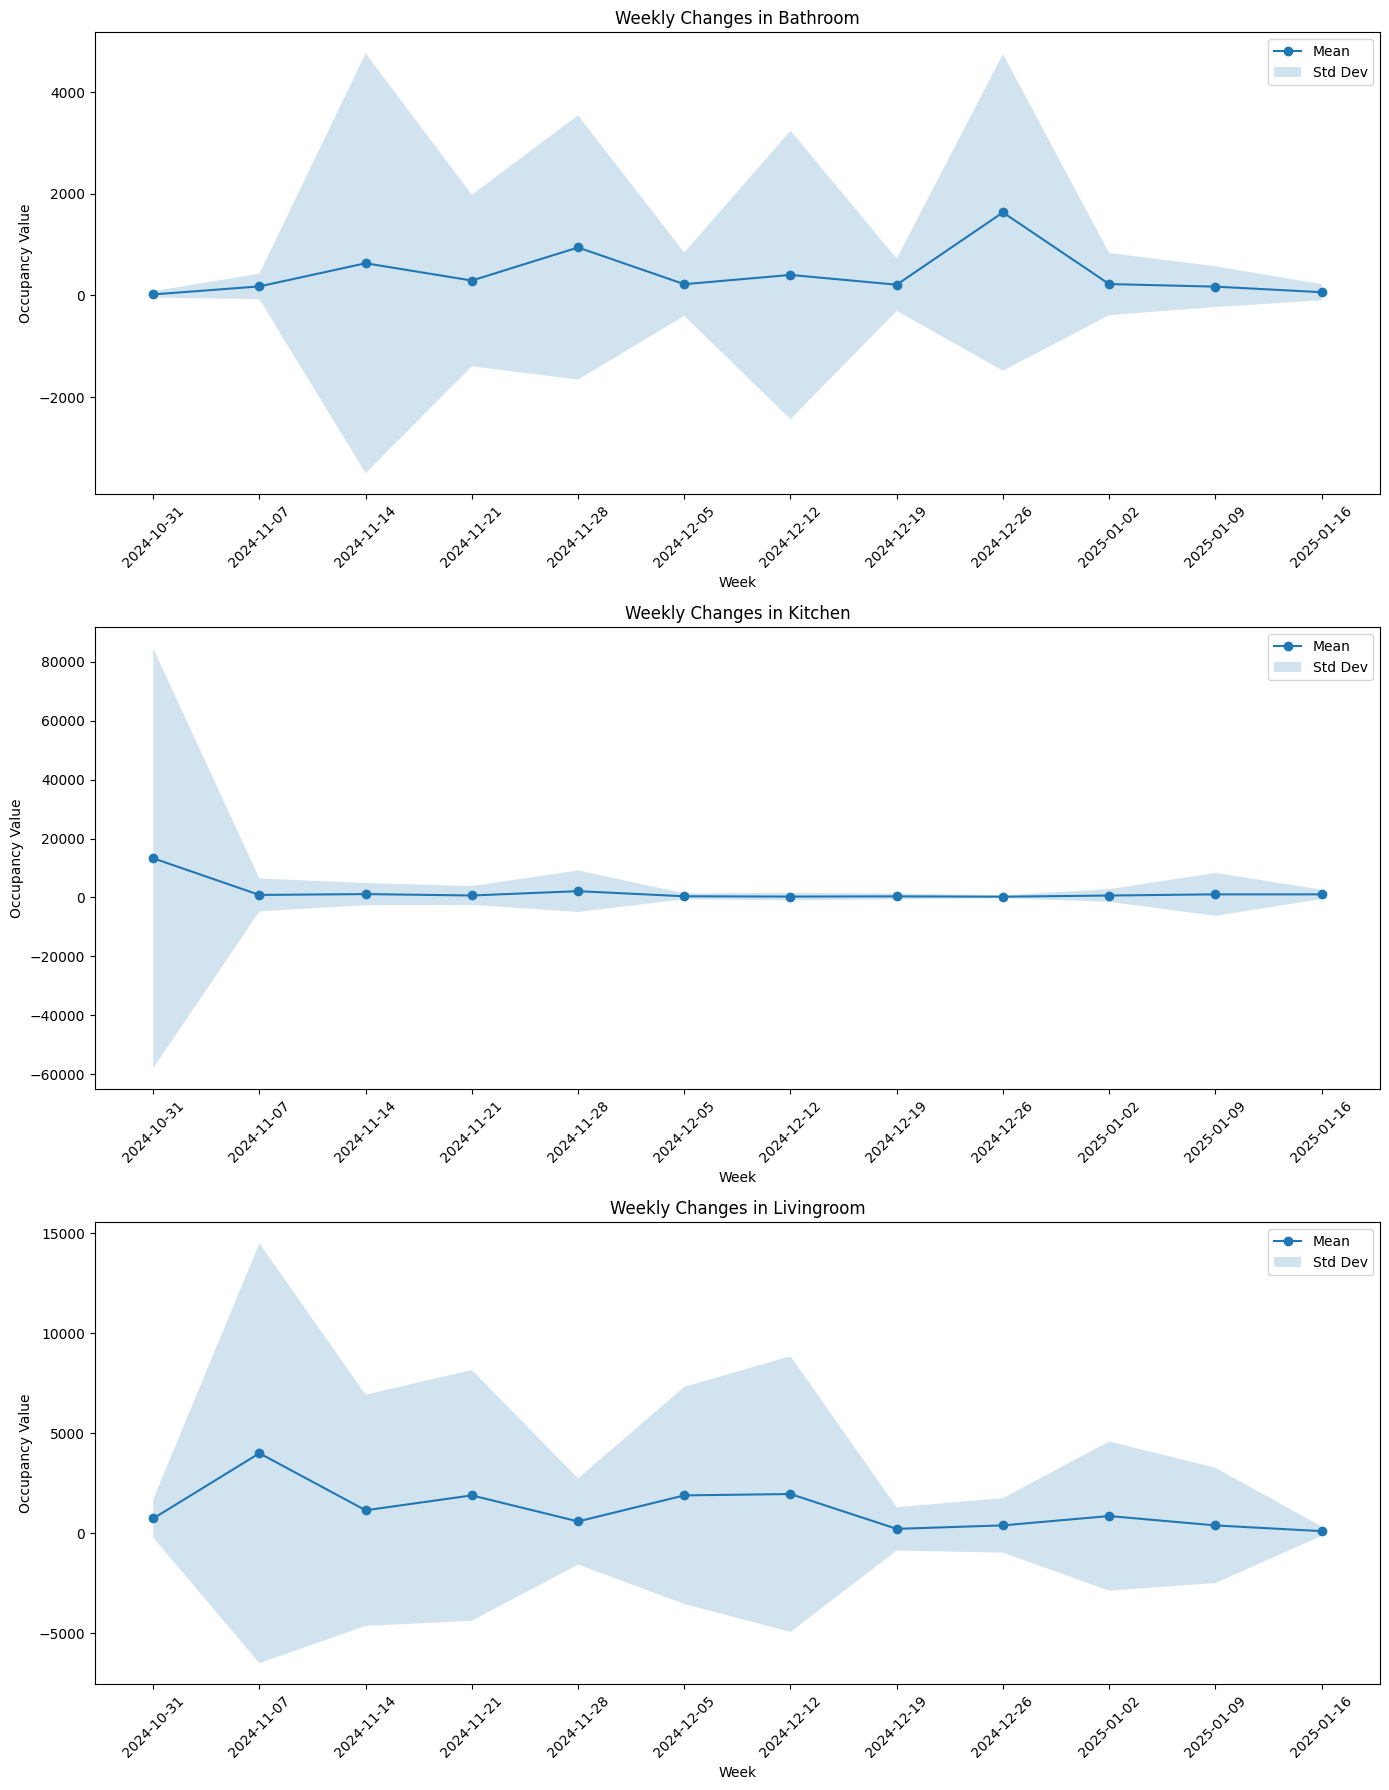

In [61]:
sensor_data_df
min_timestamp = sensor_data_df['timestamp'].min()
max_timestamp = sensor_data_df['timestamp'].max()

weekly_models = []

current_timestamp = min_timestamp
week_labels = []

while current_timestamp < max_timestamp:
    next_timestamp = current_timestamp + pd.Timedelta(weeks=1)
    weekly_data = sensor_data_df[(sensor_data_df['timestamp'] >= current_timestamp) & (sensor_data_df['timestamp'] < next_timestamp)]
    
    if not weekly_data.empty:
        model = train_occupancy_model(weekly_data)
        weekly_models.append(model)
        week_labels.append(current_timestamp.strftime('%Y-%m-%d'))
    
    current_timestamp = next_timestamp

weekly_models_df = pd.concat(weekly_models, ignore_index=True)

# Ensure only positive values
weekly_models_df['mean'] = weekly_models_df['mean'].clip(lower=0)
weekly_models_df['std'] = weekly_models_df['std'].clip(lower=0)

# Plotting the weekly changes for each room
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Bathroom
bathroom_data = weekly_models_df[weekly_models_df['room'] == 'bathroom']
axes[0].plot(week_labels, bathroom_data['mean'], marker='o', label='Mean')
axes[0].fill_between(week_labels, bathroom_data['mean'] - bathroom_data['std'], bathroom_data['mean'] + bathroom_data['std'], alpha=0.2, label='Std Dev')
axes[0].set_title('Weekly Changes in Bathroom')
axes[0].set_xlabel('Week')
axes[0].set_ylabel('Occupancy Value')
axes[0].set_xticks(week_labels)
axes[0].set_xticklabels(week_labels, rotation=45)
axes[0].legend()

# Kitchen
kitchen_data = weekly_models_df[weekly_models_df['room'] == 'kitchen']
axes[1].plot(week_labels, kitchen_data['mean'], marker='o', label='Mean')
axes[1].fill_between(week_labels, kitchen_data['mean'] - kitchen_data['std'], kitchen_data['mean'] + kitchen_data['std'], alpha=0.2, label='Std Dev')
axes[1].set_title('Weekly Changes in Kitchen')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Occupancy Value')
axes[1].set_xticks(week_labels)
axes[1].set_xticklabels(week_labels, rotation=45)
axes[1].legend()

# Livingroom
livingroom_data = weekly_models_df[weekly_models_df['room'] == 'livingroom']
axes[2].plot(week_labels, livingroom_data['mean'], marker='o', label='Mean')
axes[2].fill_between(week_labels, livingroom_data['mean'] - livingroom_data['std'], livingroom_data['mean'] + livingroom_data['std'], alpha=0.2, label='Std Dev')
axes[2].set_title('Weekly Changes in Livingroom')
axes[2].set_xlabel('Week')
axes[2].set_ylabel('Occupancy Value')
axes[2].set_xticks(week_labels)
axes[2].set_xticklabels(week_labels, rotation=45)
axes[2].legend()

plt.tight_layout()
fig.savefig('weekly_changes.pdf')
plt.show()

In [57]:
model

,room,mean,std
0,bathroom,62.79275,158.515502
1,kitchen,1053.06810,1603.568431
2,livingroom,107.89100,234.810232


In [39]:
model = load_model_from_minio("occupancy")

In [40]:
model

,room,mean,std
0,bathroom,1047.061526,26881.649307
1,kitchen,1257.734396,16011.675784
2,livingroom,1057.105833,4733.525599


In [ ]:
mode